# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 200            
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 2000      
N_scan = 9
N_test = 5

bias = True

if False: 
# if True:
    num_epochs = 100

    N_test = 0
    N_cv = 3
    N_scan = 9


p0 = 0.02         
theta0 = 0
wt = np.pi/20      
theta_std = np.pi/6



## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        p0 = self.logit0.sigmoid()
        out = p0/2 + (1-p0)*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

21.5 µs ± 70.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.84960
Iteration: 3 - Loss: 0.81026
Iteration: 6 - Loss: 0.77641
Iteration: 9 - Loss: 0.74708
Iteration: 12 - Loss: 0.72020
Iteration: 15 - Loss: 0.69781
Iteration: 18 - Loss: 0.67825
Iteration: 21 - Loss: 0.66035
Iteration: 24 - Loss: 0.64432
Iteration: 27 - Loss: 0.62926
Iteration: 30 - Loss: 0.61515
Iteration: 33 - Loss: 0.60187
Iteration: 36 - Loss: 0.58868
Iteration: 39 - Loss: 0.57638
Iteration: 42 - Loss: 0.56470
Iteration: 45 - Loss: 0.55343
Iteration: 48 - Loss: 0.54246
Iteration: 51 - Loss: 0.53243
Iteration: 54 - Loss: 0.52297
Iteration: 57 - Loss: 0.51383
Iteration: 60 - Loss: 0.50533
Iteration: 63 - Loss: 0.49737
Iteration: 66 - Loss: 0.48985
Iteration: 69 - Loss: 0.48262
Iteration: 72 - Loss: 0.47599
Iteration: 75 - Loss: 0.46975
Iteration: 78 - Loss: 0.46374
Iteration: 81 - Loss: 0.45826
Iteration: 84 - Loss: 0.45290
Iteration: 87 - Loss: 0.44790
Iteration: 90 - Loss: 0.44325
Iteration: 93 - Loss: 0.43870
Iteration: 96 - Loss: 0.43454
Iteration: 99 

In [8]:
with torch.no_grad():
    if bias: print(f'bias {-logistic_model.linear.bias.item()/logistic_model.linear.weight.item():.3f}; theta0 {theta0:.3f}' )
    print(f'slope {1/logistic_model.linear.weight.item():.3f} ; slope true {wt}')    
    print(f'p0 {torch.sigmoid(logistic_model.logit0).item():.3f} p0 true = {p0}')


bias 0.017; theta0 0.000
slope 0.392 ; slope true 0.15707963267948966
p0 0.025 p0 true = 0.02


loss= 0.43043301203303125


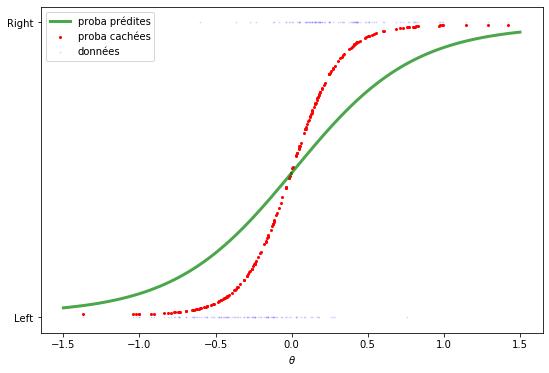

In [9]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

320 ms ± 9.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.4296, grad_fn=<BinaryCrossEntropyBackward>)


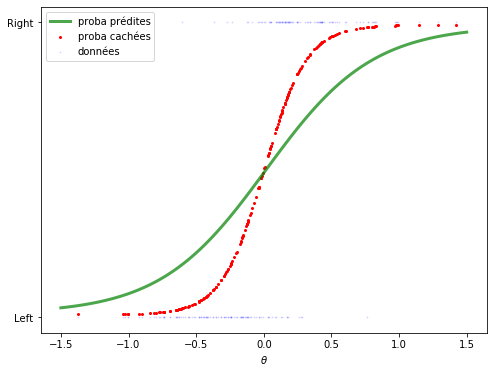

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [12]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.35411, loss_P: 0.52610, loss_P0: 0.40498
N: 17, Loss: 0.43511, loss_P: 0.45200, loss_P0: 0.37256
N: 31, Loss: 0.46606, loss_P: 0.42306, loss_P0: 0.38175
N: 56, Loss: 0.42760, loss_P: 0.43906, loss_P0: 0.36835
N: 100, Loss: 0.45112, loss_P: 0.43428, loss_P0: 0.38382
N: 177, Loss: 0.41657, loss_P: 0.41802, loss_P0: 0.37502
N: 316, Loss: 0.38462, loss_P: 0.39205, loss_P0: 0.36445
N: 562, Loss: 0.43005, loss_P: 0.43621, loss_P0: 0.36203
N: 1000, Loss: 0.40910, loss_P: 0.41722, loss_P0: 0.36114


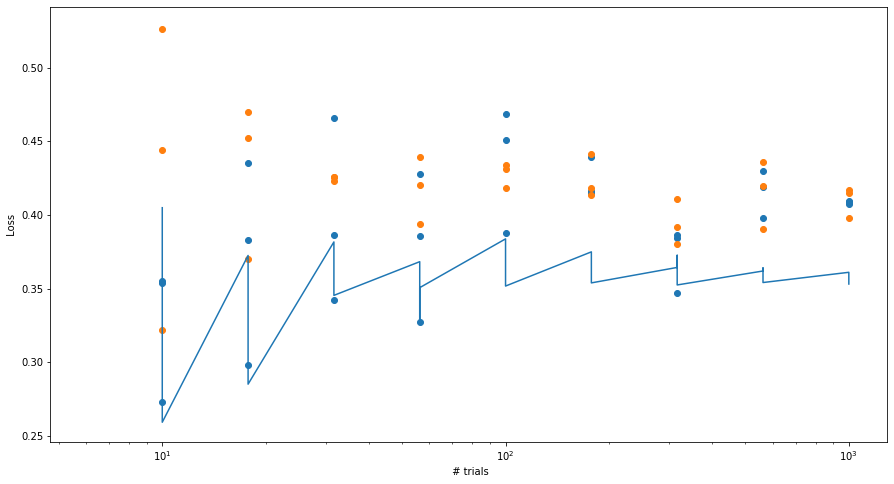

In [13]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [14]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.73990, loss_P: 0.73897, loss_P0: 0.37572
learning_rate: 0.00711, Loss: 0.59852, loss_P: 0.60252, loss_P0: 0.37572
learning_rate: 0.01265, Loss: 0.51017, loss_P: 0.51884, loss_P0: 0.37572
learning_rate: 0.02249, Loss: 0.49121, loss_P: 0.50112, loss_P0: 0.37572
learning_rate: 0.04000, Loss: 0.38600, loss_P: 0.40678, loss_P0: 0.37572
learning_rate: 0.07113, Loss: 0.35535, loss_P: 0.38325, loss_P0: 0.37572
learning_rate: 0.12649, Loss: 0.34369, loss_P: 0.37699, loss_P0: 0.37572
learning_rate: 0.22494, Loss: 0.33777, loss_P: 0.37692, loss_P0: 0.37572
learning_rate: 0.40000, Loss: 0.33193, loss_P: 0.37898, loss_P0: 0.37572


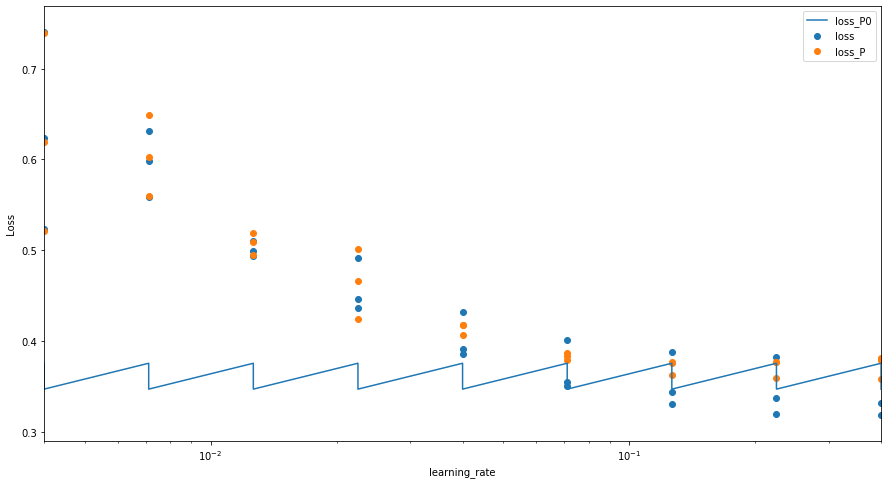

In [15]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [16]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 10, Loss: 0.54544, loss_P: 0.55268, loss_P0: 0.37572
num_epochs: 17, Loss: 0.69736, loss_P: 0.69813, loss_P0: 0.37572
num_epochs: 31, Loss: 0.47028, loss_P: 0.48174, loss_P0: 0.37572
num_epochs: 56, Loss: 0.42978, loss_P: 0.44489, loss_P0: 0.37572
num_epochs: 100, Loss: 0.44894, loss_P: 0.46216, loss_P0: 0.37572
num_epochs: 177, Loss: 0.37045, loss_P: 0.39424, loss_P0: 0.37572
num_epochs: 316, Loss: 0.34055, loss_P: 0.37640, loss_P0: 0.37572
num_epochs: 562, Loss: 0.33624, loss_P: 0.37652, loss_P0: 0.37572
num_epochs: 1000, Loss: 0.33060, loss_P: 0.38307, loss_P0: 0.37572


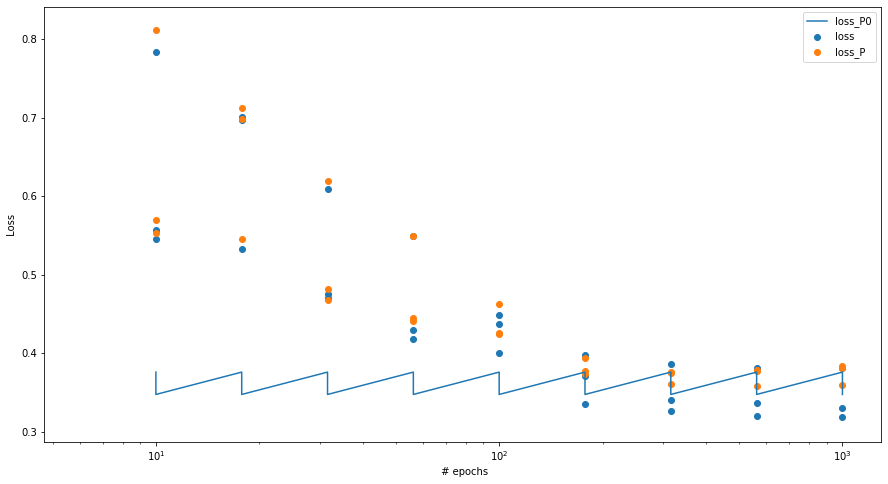

In [17]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [18]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 25, Loss: 0.37936, loss_P: 0.40138, loss_P0: 0.37572
batch_size: 32, Loss: 0.37915, loss_P: 0.40134, loss_P0: 0.37572
batch_size: 42, Loss: 0.43088, loss_P: 0.44587, loss_P0: 0.37572
batch_size: 54, Loss: 0.44920, loss_P: 0.46248, loss_P0: 0.37572
batch_size: 70, Loss: 0.40647, loss_P: 0.42419, loss_P0: 0.37572
batch_size: 91, Loss: 0.39709, loss_P: 0.41585, loss_P0: 0.37572
batch_size: 118, Loss: 0.38566, loss_P: 0.40653, loss_P0: 0.37572
batch_size: 154, Loss: 0.41239, loss_P: 0.42930, loss_P0: 0.37572
batch_size: 200, Loss: 0.39527, loss_P: 0.41455, loss_P0: 0.37572


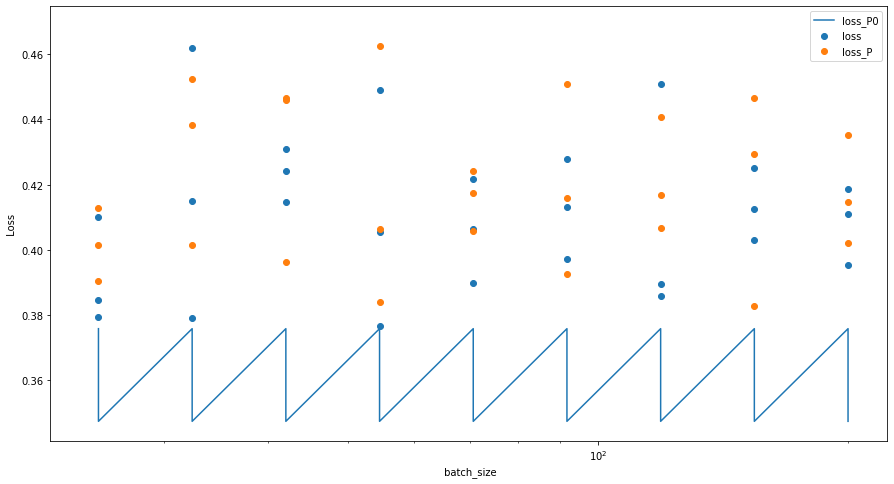

In [19]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

## Torch

In [20]:
theta0s = theta_std*np.random.randn(N_scan*N_cv)
p0s = np.linspace(0, 1, N_scan*N_cv)
wts = np.logspace(-1, 1, N_scan*N_cv, base=10)

#preds = {'torch':{'theta0_preds':[], 'wt_preds':[], 'p0_preds':[]}, 
#         'sklearn':{'theta0_preds':[], 'wt_preds':[], 'p0_preds':[]}}

p0_preds, theta0_preds, wt_preds = [],[],[]

for i_, p0_ in enumerate(p0s): 
    theta, p, y = get_data(p0=p0_,seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()            
    p0_preds.append(p0_pred)
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y = get_data(theta0=theta0_,seed=seed + i_) 
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta0_pred = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item() 
    theta0_preds.append(theta0_pred)
                   
for i_, wt_ in enumerate(wts):
    theta, p, y = get_data(wt=wt_, seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    wt_pred = 1/logistic_model.linear.weight.item() 
    wt_preds.append(wt_pred)
    
        
      

## Sklearn

In [32]:
def fit_lr(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed = seed):
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)*wt
    p = p0/2 + ((1-p0)/(1+np.exp(-a)))
    y = np.random.rand(N) < p 

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(solver='liblinear', max_iter=num_epochs) #, C = 3, penalty='l2', class_weight = {1 : 1 , 0 : 1})
    model.fit(theta[:, None], y)
    return theta, p, y, model



In [33]:
theta0_pre, wt_pre  = [],[]
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y, model = fit_lr(theta0=theta0_, seed=seed + i_)
    theta0_pre.append(-model.intercept_[0]/model.coef_[0][0])

for i_, wt_ in enumerate(wts):
    theta, p, y, model = fit_lr(wt=wt_, seed=seed + i_)
    wt_pre.append(model.coef_[0][0])


In [34]:
model.intercept_

array([-0.04126745])

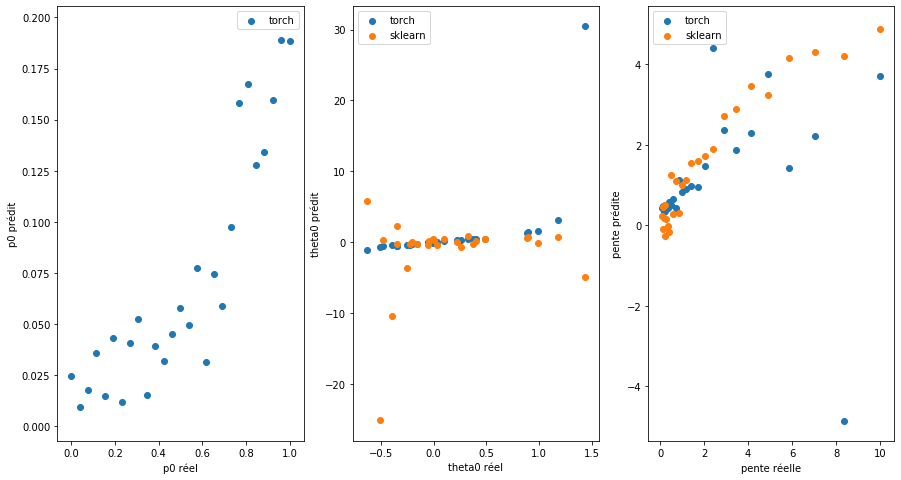

In [35]:
# TODO : show three panels

fig, axs= plt.subplots(1, 3, figsize = (15, 8)) 

axs[0].scatter(p0s, p0_preds, label='torch')
#axs[0].scatter(0, 0, label='sklearn')
axs[0].set(xlabel='p0 réel',ylabel='p0 prédit')
axs[0].legend()

axs[1].scatter(theta0s, theta0_preds,label='torch')
axs[1].scatter(theta0s, theta0_pre,label='sklearn')
axs[1].set(xlabel='theta0 réel',ylabel='theta0 prédit')
axs[1].legend()

axs[2].scatter(wts, wt_preds,label='torch')
axs[2].scatter(wts, wt_pre,label='sklearn')
axs[2].set(xlabel='pente réelle',ylabel='pente prédite')
axs[2].legend();